In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
! pip install catboost

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, OneSidedSelection
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Set random seed to ensure reproducible runs
RSEED = 50

In [0]:
#from sklearn.externals import joblib
#data = joblib.load('./gdrive/My Drive/Colab Notebooks/Pruebas/df2.pkl')

In [24]:
df = pd.read_csv('./gdrive/My Drive/Colab Notebooks/Algoritmos/dataset.csv')
#data = data.drop(columns=['time', 'measure', 'capture'])#,'ip_flags_resbit','ip_flags_morefrag','ip_frag_offset','tcp_flags_cong_window_reduced','tcp_flags_explicit_cong_notif','tcp_flags_urg_pointer'])

df['stalling_event'].value_counts()
#unbalanced

0    643842
1     95196
Name: stalling_event, dtype: int64

In [0]:
df2 = df[['pkt_length', 'tcp_window_size_value', 'ip_len', 'tcp_flags_ack', 'tcp_flags_reset', 'tcp_flags_syn']].rolling(8).mean()
df2['stalling_event'] = df.stalling_event.values
#df2['measure'] = df.measure.values
#df2['capture'] = df.capture.values

In [0]:
data = df2.dropna()

In [0]:
#extract labels
X = data.drop(['stalling_event'], axis=1)
y = data['stalling_event']

#30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                          stratify = y,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)
features = list(X_train.columns)
#For column importance

 #smt = SMOTE(random_state=RSEED, n_jobs=-1)
#X_train, y_train = smt.fit_sample(X_train, y_train)


In [28]:
X_train

,pkt_length,tcp_window_size_value,ip_len,tcp_flags_ack,tcp_flags_reset,tcp_flags_syn
636186,1149.000,48211.000,1135.000,1.00,0.00,0.0
56763,966.500,46283.750,952.500,1.00,0.00,0.0
32214,1149.000,48212.500,1135.000,1.00,0.00,0.0
163128,633.625,32422.000,619.625,1.00,0.00,0.0
588427,790.000,32422.000,776.000,1.00,0.00,0.0
516892,966.500,40234.750,952.500,1.00,0.00,0.0
325631,846.125,64472.625,832.125,1.00,0.00,0.0
728747,868.000,46498.875,854.000,1.00,0.00,0.0
381667,966.500,63980.000,952.500,1.00,0.00,0.0
566453,708.375,32421.500,694.375,1.00,0.00,0.0


In [0]:
#sum(X_train[:,-3]>1)

In [30]:
print('Train shape: ' + str(X_train.shape) + ' Test shape: ' + str(X_test.shape))

Train shape: (517321, 6) Test shape: (221710, 6)


In [39]:
#class_weight = {}
class_weight = compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
#model = RandomForestClassifier(n_estimators=100,
 #                             random_state = RSEED,
  #                            max_features = 'sqrt',
   #                           n_jobs=-1, verbose = 1)#, class_weight=dict(enumerate(class_weight)))#, class_weight={0: w_neg, 1: w_pos})##, class_weight="balanced_subsample")
#"1":3.881672344,"0":0.5739279193
model = CatBoostClassifier(random_state=RSEED, verbose=1)#, n_estimators=100)#, class_weights=class_weight)
model.fit(X_train, y_train)

Learning rate set to 0.098202
0:	learn: 0.6210987	total: 199ms	remaining: 3m 19s
1:	learn: 0.5640700	total: 371ms	remaining: 3m 5s
2:	learn: 0.5199902	total: 563ms	remaining: 3m 6s
3:	learn: 0.4861678	total: 722ms	remaining: 2m 59s
4:	learn: 0.4574290	total: 901ms	remaining: 2m 59s
5:	learn: 0.4358226	total: 1.07s	remaining: 2m 57s
6:	learn: 0.4192847	total: 1.24s	remaining: 2m 56s
7:	learn: 0.4058629	total: 1.41s	remaining: 2m 55s
8:	learn: 0.3953709	total: 1.61s	remaining: 2m 57s
9:	learn: 0.3868702	total: 1.78s	remaining: 2m 56s
10:	learn: 0.3804149	total: 1.95s	remaining: 2m 55s
11:	learn: 0.3753087	total: 2.12s	remaining: 2m 54s
12:	learn: 0.3710556	total: 2.29s	remaining: 2m 53s
13:	learn: 0.3674625	total: 2.45s	remaining: 2m 52s
14:	learn: 0.3642901	total: 2.65s	remaining: 2m 53s
15:	learn: 0.3610196	total: 2.83s	remaining: 2m 53s
16:	learn: 0.3582385	total: 3s	remaining: 2m 53s
17:	learn: 0.3565565	total: 3.16s	remaining: 2m 52s
18:	learn: 0.3547348	total: 3.33s	remaining: 2m 5

In [0]:
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

In [41]:
from sklearn.metrics import classification_report
#f1-score mejor=1 peor=0
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    193151
           1       0.77      0.21      0.33     28559

    accuracy                           0.89    221710
   macro avg       0.83      0.60      0.63    221710
weighted avg       0.88      0.89      0.86    221710



In [42]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model

,feature,importance
1,tcp_window_size_value,87.850557
0,pkt_length,4.616748
2,ip_len,3.561248
4,tcp_flags_reset,2.062429
3,tcp_flags_ack,0.996949
5,tcp_flags_syn,0.912068


In [0]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


Recall Baseline: 1.0 Test: 0.2 Train: 0.2
Precision Baseline: 0.13 Test: 0.75 Train: 0.76
Roc Baseline: 0.5 Test: 0.82 Train: 0.82


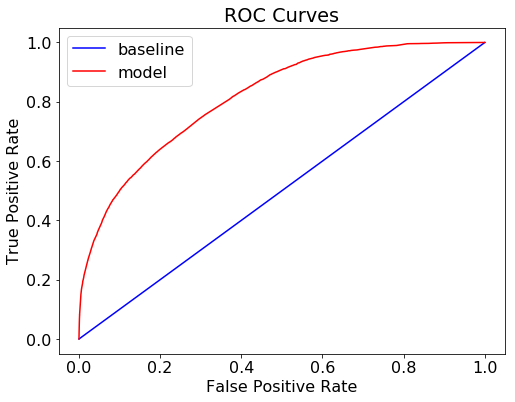

In [36]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[191303   1848]
 [ 22960   5599]]


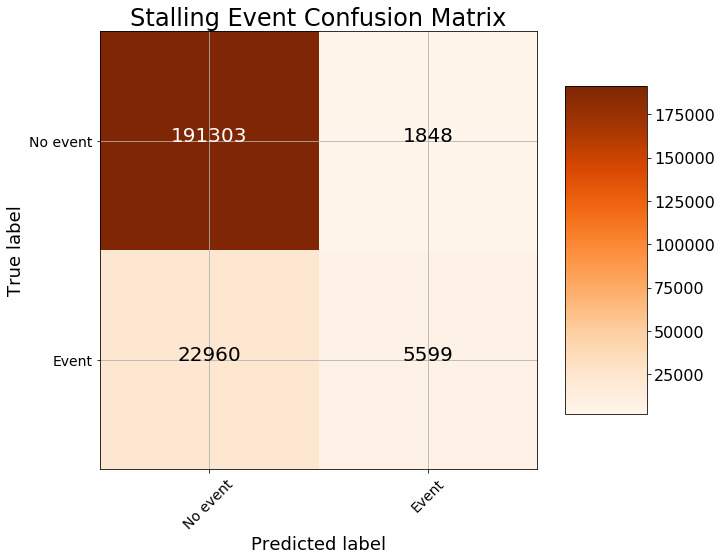

In [38]:
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['No event', 'Event'],
                      title = 'Stalling Event Confusion Matrix')